In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageFile

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import timm
from torchvision import transforms, models, datasets
import os
import faiss
from skimage import feature
from skimage import measure
import skimage
from revisited_dataset import RevisitedDataset

In [5]:
root = 'E:/Datasets/paris/rparis6k'

# Initial Parameters

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [8]:
path = 'E:/Datasets/paris/'
root = 'E:/Datasets/paris/rparis6k'

In [9]:
checkpoint_names =  ['vit_tiny_patch16_224',
                     'vit_tiny_patch16_224_in21k',
                     'vit_base_patch16_224',
                     'vit_base_patch16_384,']

# Loading data and model

In [10]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [11]:
offline_dataset = RevisitedDataset(root=root, phase='database', transform=transform)
online_dataset  = RevisitedDataset(root=root, phase='query', setup='hard', transform=transform)

offline_loader  = DataLoader(offline_dataset, batch_size=64)
online_loader   = DataLoader(online_dataset, batch_size=1)

In [153]:
model = timm.create_model(checkpoint_names[0], pretrained=True,).to(device)
model.head = nn.Identity()
model.eval()
# embed_dim = 768
embed_dim = 192

# Local desctiptor ReRanking

In [13]:
qdataset  = RevisitedDataset(root=root, phase='query', setup='hard')
bdataset  = RevisitedDataset(root=root, phase='database')

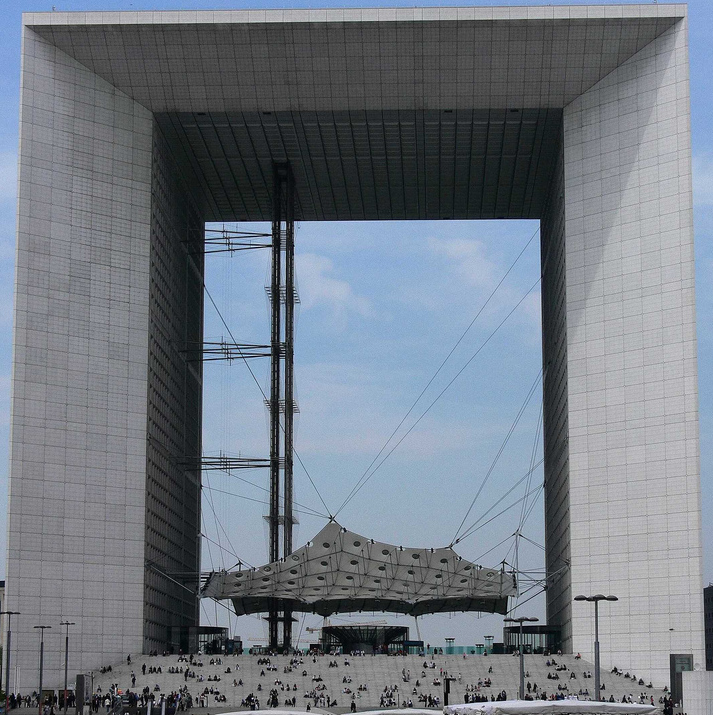

In [14]:
qdataset[0][0]

In [92]:
import stitching

In [99]:
import matplotlib.pyplot as plt

In [88]:
from skimage import filters
from skimage.feature import corner_peaks
from skimage.io import imread

In [ ]:
keypoints1 = corner_peaks(stitching.harris_corners(img1, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)
keypoints2 = corner_peaks(stitching.harris_corners(img2, window_size=3),
                          threshold_rel=0.05,
                          exclude_border=8)

In [95]:
from skimage.feature import match_descriptors, plot_matches, SIFT
from skimage.color import rgb2gray


In [100]:
img1 = rgb2gray(qdataset[0][0])
img2 = rgb2gray(bdataset[114])

In [94]:
descriptor_extractor = SIFT()

In [102]:
descriptor_extractor.detect_and_extract(img1)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(img2)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [108]:
matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=0.6,
                              cross_check=True)

TypeError: 'AxesSubplot' object is not subscriptable

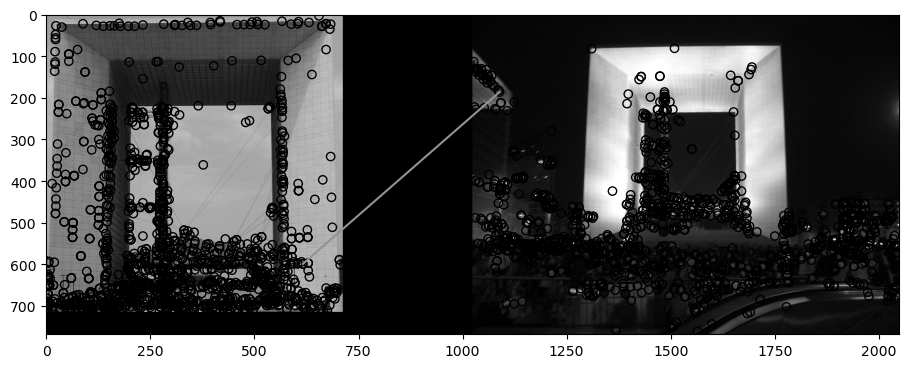

In [111]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
plt.gray()

plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
ax[0, 0].axis('off')
ax[0, 0].set_title("Original Image vs. Flipped Image\n"
                   "(all keypoints and matches)")

In [15]:
pos_img = transform(bdataset[114])
pos_img = pos_img.expand(1, -1, -1, -1)
pos_img = pos_img.to(device)

neg_img = transform(bdataset[300])
neg_img = neg_img.expand(1, -1, -1, -1)
neg_img = neg_img.to(device)

In [116]:
qimg, gndt = iter(online_loader).next()
qimg = qimg.to(device)

In [17]:
img_features = model.forward_features(qimg)[:,1:][0].cpu().detach().numpy()
pos_features = model.forward_features(pos_img)[:,1:][0].cpu().detach().numpy()
neg_features = model.forward_features(neg_img)[:,1:][0].cpu().detach().numpy()

In [137]:
img_features.shape

(196, 192)

ransac

In [22]:
from scipy import spatial

In [78]:
d1_tree = spatial.cKDTree(img_features)
_, indices = d1_tree.query(pos_features)

In [26]:
num_features = img_features.shape[0]

In [69]:
loc = np.empty((196, 2), dtype=np.int32)
k = 0
for i in range(14):
    for j in range(14):
            loc[k, 0] =  i
            loc[k, 1] =  j
            k += 1

In [79]:
indices

array([ 13,  13,  13,  13,  79,  79,  79,  79,  79,  79,  79,  79,  79,
        13,  46,  13,  79,   2,  59,  62,  62,  62,  63,  62,   2,  79,
        79,  79,  25,  13,  79,  67,  15,  79,  79,  76,  79,  16, 142,
        79,  79,  79,  15,  11,  79, 112,  54,  68,  68,  68,  54,  54,
       100,  79,  79,  59, 195,  46,  79, 128,  54, 156,  66,  38,  31,
        76, 142,  79,  79,  54,  46,  46,  13, 156,  76, 111,  86,  86,
       109,  76, 111,  46,  79,  46,  59,  73, 118, 156,  76,  67, 156,
        59, 109,  76, 128,  46,  13,  13, 141, 120, 156, 156,  79, 111,
       156,  86, 123, 120, 109,  13,  13,  13, 170, 168, 195, 156, 195,
        54, 179, 182, 128, 120, 109, 171, 177, 195, 182, 195, 184, 177,
        54, 195, 191, 195, 160, 170, 195, 184, 195, 195, 195, 184, 185,
       187, 185, 190, 185,  46, 182, 182, 195, 185, 195, 182, 171, 185,
       195,  46, 184, 184, 195, 182, 190, 185, 195, 182, 182, 171, 195,
       195,  13, 195, 184, 184, 195,  46, 182, 182, 182, 182, 18

In [80]:
locations_2_to_use = np.array([loc[i,]          for i in range(num_features)    if indices[i] != num_features])
locations_1_to_use = np.array([loc[indices[i],] for i in range(num_features)    if indices[i] != num_features])

In [81]:
_, inliers = measure.ransac((locations_1_to_use, locations_2_to_use),
                              skimage.transform.AffineTransform,
                              min_samples=3,
                              residual_threshold=20,
                              max_trials=1000)

In [82]:
inliers

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision
import timm
import torchxrayvision as xrv
import copy
import os

In [133]:
ranker = timm.create_model(checkpoint_names[0], pretrained=True, num_classes=1).cuda()

In [ ]:
dataloaders = [offline_loader, online_loader]

In [134]:
ranker(qimg)

tensor([[-1.7390]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [135]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ranker.parameters(), lr=1e-3, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=15, device='cuda'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.
    best_loss = 10000

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ('train', 'val'):
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.
            running_corrects = 0
            num_inputs = 0.
            for data in dataloaders[phase]:
                inputs = data['img'].permute(0, 2, 3, 1).to(device)
                labels = data['lab'][:, 0].to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                num_inputs += inputs.size(0)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / num_inputs
            epoch_acc  = running_corrects.double() / num_inputs

            print(f'{phase} Loss: {epoch_loss} | Acc: {epoch_acc}')

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
        print()

    print(f'Best val Acc: {best_acc:4f} | loss: {best_loss:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
ranker = train(ranker, dataloaders, criterion, optimizer, scheduler)